# **Setting up for Colab**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import os
import pandas as pd
from pathlib import Path


# Define projectfolder
eb_main = '/content/drive/MyDrive/EB_project/ebnerd-benchmark-main/src'


# Change project folder
os.chdir(eb_main)
print("Current working directory:", os.getcwd())



Current working directory: /content/drive/MyDrive/EB_project/ebnerd-benchmark-main/src


# **Import**



In [ ]:
from transformers import AutoTokenizer, AutoModel
from pathlib import Path
import tensorflow as tf
import polars as pl

from ebrec.utils._constants import (
    DEFAULT_HISTORY_ARTICLE_ID_COL,
    DEFAULT_CLICKED_ARTICLES_COL,
    DEFAULT_INVIEW_ARTICLES_COL,
    DEFAULT_IMPRESSION_ID_COL,
    DEFAULT_SUBTITLE_COL,
    DEFAULT_LABELS_COL,
    DEFAULT_TITLE_COL,
    DEFAULT_USER_COL,
    DEFAULT_IMPRESSION_TIMESTAMP_COL,
)

from ebrec.utils._behaviors import (
    create_binary_labels_column,
    sampling_strategy_wu2019,
    add_known_user_column,
    add_prediction_scores,
    truncate_history,
)

from ebrec.evaluation import MetricEvaluator, AucScore, NdcgScore, MrrScore, F1Score
from ebrec.utils._articles import convert_text2encoding_with_transformers
from ebrec.utils._polars import concat_str_columns, slice_join_dataframes
from ebrec.utils._articles import create_article_id_to_value_mapping
from ebrec.utils._nlp import get_transformers_word_embeddings
from ebrec.utils._python import write_submission_file, rank_predictions_by_score

from ebrec.models.newsrec.dataloader import NRMSDataLoader
from ebrec.models.newsrec.model_config import hparams_nrms
# from ebrec.models.newsrec.nrms_pytorch import NRMSModel

## Load dataset

In [ ]:
def ebnerd_from_path(path: Path, history_size: int = 30, padding: int = 0,) -> pl.DataFrame:
    """
    Load ebnerd - function
    """
    df_history = (
        pl.scan_parquet(path.joinpath("history.parquet"))
        .select(DEFAULT_USER_COL, DEFAULT_HISTORY_ARTICLE_ID_COL)
        .pipe(
            truncate_history,
            column=DEFAULT_HISTORY_ARTICLE_ID_COL,
            history_size=history_size,
            padding_value=0,
            enable_warning=False,
        )
    )
    df_behaviors = (
        pl.scan_parquet(path.joinpath("behaviors.parquet"))
        .collect()
        .pipe(
            slice_join_dataframes,
            df2=df_history.collect(),
            on=DEFAULT_USER_COL,
            how="left",
        )
    )
    return df_behaviors

# **Making folder for the model**

In [ ]:
from pathlib import Path

PATH = Path("/content/drive/MyDrive/EB_project").expanduser()

# Datasplit-folder
DATASPLIT = "ebnerd_small"

DUMP_DIR = PATH.joinpath("dump_artifacts")
DUMP_DIR.mkdir(exist_ok=True, parents=True)

print(f"PATH: {PATH}")
print(f"DUMP_DIR: {DUMP_DIR}")


PATH: /content/drive/MyDrive/EB_project
DUMP_DIR: /content/drive/MyDrive/EB_project/dump_artifacts


# **Load dataset**

In [ ]:
COLUMNS = [
    DEFAULT_USER_COL,
    DEFAULT_IMPRESSION_ID_COL,
    DEFAULT_IMPRESSION_TIMESTAMP_COL,
    DEFAULT_HISTORY_ARTICLE_ID_COL,
    DEFAULT_CLICKED_ARTICLES_COL,
    DEFAULT_INVIEW_ARTICLES_COL,
]
HISTORY_SIZE = 20
FRACTION = 1


import datetime
df = (
    ebnerd_from_path(
        PATH.joinpath(DATASPLIT, "train"), history_size=HISTORY_SIZE,
        padding=0,
    )
    .select(COLUMNS)
    .pipe(
        sampling_strategy_wu2019,
        npratio=4,
        shuffle=True,
        with_replacement=True,
        seed=123,
    )
    .pipe(create_binary_labels_column)
    .sample(fraction=FRACTION, seed=123) # Ensure consistent fraction sampling
)
dt_split = pl.col(DEFAULT_IMPRESSION_TIMESTAMP_COL).max() - datetime.timedelta(days=1)
df_train = df.filter(pl.col(DEFAULT_IMPRESSION_TIMESTAMP_COL) < dt_split)
df_validation = df.filter(pl.col(DEFAULT_IMPRESSION_TIMESTAMP_COL) >= dt_split)


## **Numbers of users used for the training loop**

In [ ]:
print("Train:",len(df_train))
print("Validation:",len(df_validation))
print("Total:",len(df_train)+len(df_validation))

Train: 201537
Validation: 32740
Total: 234277


# **Load articles**

In [ ]:
df_articles = pl.read_parquet(PATH.joinpath(DATASPLIT,"articles.parquet"))
print("Articles:", len(df_articles))

Articles: 20738


# **Preprocessing subtitle**

In [ ]:
pre_proc = '/content/drive/MyDrive/EB_project/ebnerd-benchmark-main/examples/00_quick_start'
os.chdir(pre_proc)

from preproc_pred import clean_text_column


# Convert subtitle column to a list, clean it, and add it back
cleaned_subtitles = df_articles["subtitle"].to_list()
cleaned_subtitles = [clean_text_column(text) for text in cleaned_subtitles]

# Add the cleaned subtitles as a new column
df_articles = df_articles.with_columns(
    pl.Series("subtitle_cleaned", cleaned_subtitles)
)


#**Load LLM**

## **ROBERTa** (Use Roberta if you want to run a new training loop)

In [ ]:
# Load model
from transformers import AutoTokenizer, AutoModelForMaskedLM

TRANSFORMER_MODEL_NAME = "FacebookAI/xlm-roberta-base"


# LOAD HUGGINGFACE:
transformer_model = AutoModel.from_pretrained(TRANSFORMER_MODEL_NAME)
transformer_tokenizer = AutoTokenizer.from_pretrained(TRANSFORMER_MODEL_NAME)



TEXT_COLUMNS_TO_USE = ["title", "subtitle_cleaned"]
MAX_TITLE_LENGTH = 20

word2vec_embedding = get_transformers_word_embeddings(transformer_model)

df_articles, cat_cal = concat_str_columns(df_articles, columns=TEXT_COLUMNS_TO_USE)
df_articles, token_col_title = convert_text2encoding_with_transformers(
    df_articles, transformer_tokenizer, cat_cal, max_length=MAX_TITLE_LENGTH
)
# =>
article_mapping = create_article_id_to_value_mapping(
    df=df_articles, value_col=token_col_title
)


## **Glove embeddings** (This part should not be executed )

In [ ]:
import torch
from tokenizers import Tokenizer, normalizers, pre_tokenizers, models
from pathlib import Path
from huggingface_hub import hf_hub_download
import zipfile
from tqdm import tqdm
from typing import Tuple, List
import numpy as np

# Funktion til at loade GloVe-vectors
def load_glove_vectors(filename="glove.6B.300d.txt") -> Tuple[List[str], torch.Tensor]:
    """Load the GloVe vectors. See: `https://github.com/stanfordnlp/GloVe`"""
    path = Path(hf_hub_download(repo_id="stanfordnlp/glove", filename="glove.6B.zip"))
    target_file = path.parent / filename
    if not target_file.exists():
        with zipfile.ZipFile(path, 'r') as zip_ref:
            zip_ref.extractall(path.parent)

        if not target_file.exists():
            print(f"Available files:")
            for p in path.parent.iterdir():
                print(p)
            raise ValueError(f"Target file `{target_file.name}` can't be found. Check if `{filename}` was properly downloaded.")

    # Parse vocabulary and vectors
    vocabulary = []
    vectors = []
    with open(target_file, "r", encoding="utf8") as f:
        for l in tqdm(f.readlines(), desc=f"Parsing {target_file.name}..."):
            word, *vector = l.split()
            vocabulary.append(word)
            vectors.append(torch.tensor([float(v) for v in vector]))
    vectors = torch.stack(vectors)
    return vocabulary, vectors

# Indlæs GloVe-data
glove_vocabulary, glove_vectors = load_glove_vectors()

# Tilføj special tokens
special_tokens = ['<|start|>', '<|unknown|>', '<|pad|>']
glove_vocabulary = special_tokens + glove_vocabulary
special_vectors = torch.randn((len(special_tokens), glove_vectors.shape[1]))  # Tilføj tilfældige vektorer for special tokens
glove_vectors = torch.cat([special_vectors, glove_vectors])

# GloVe-tokenizer
glove_tokenizer = Tokenizer(models.WordLevel(vocab={v: i for i, v in enumerate(glove_vocabulary)}, unk_token="<|unknown|>"))
glove_tokenizer.normalizer = normalizers.BertNormalizer(strip_accents=False)
glove_tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()




/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


glove.6B.zip:   0%|          | 0.00/862M [00:00<?, ?B/s]

Parsing glove.6B.300d.txt...: 100%|██████████| 400001/400001 [00:47<00:00, 8426.48it/s]


In [ ]:
class GloveTokenizerWrapper:
    def __init__(self, glove_tokenizer, name_or_path="glove_tokenizer"):
        self.glove_tokenizer = glove_tokenizer
        self.name_or_path = name_or_path

    def __call__(self, text, add_special_tokens=False, padding=False, max_length=None, truncation=False):
        # Encode teksten
        if isinstance(text, str):
            text = [text]  # Sørg for, at det er en liste

        # Tokenize batch
        encoded = self.glove_tokenizer.encode_batch(text)
        token_ids = [e.ids for e in encoded]

        # Håndtering af truncation og padding
        if truncation or padding:
            token_ids = [
                tokens[:max_length] + [0] * max(0, max_length - len(tokens))
                if max_length else tokens
                for tokens in token_ids
            ]

        # Returnér som et dict for at matche transformers-output
        return {"input_ids": token_ids}

wrapped_glove_tokenizer = GloveTokenizerWrapper(glove_tokenizer)

In [ ]:

TEXT_COLUMNS_TO_USE = ["title", "subtitle_cleaned"]
MAX_TITLE_LENGTH = 30
# We'll init the word embeddings using the
# Konverter embeddings til numpy
word2vec_embedding = glove_vectors.numpy()
df_articles, cat_cal = concat_str_columns(df_articles, columns=TEXT_COLUMNS_TO_USE)


df_articles, token_col_title = convert_text2encoding_with_transformers(
    df_articles, wrapped_glove_tokenizer, cat_cal, max_length=MAX_TITLE_LENGTH
)
# =>
article_mapping = create_article_id_to_value_mapping(
    df=df_articles, value_col=token_col_title
)



# Udskriv kompatibelt output
print(f"Tokenizer vocab size: {len(glove_vocabulary)}")
print(f"Word2Vec embedding shape: {word2vec_embedding.shape}")

Tokenizer vocab size: 400004
Word2Vec embedding shape: (400004, 300)


In [ ]:
'''word = "king"  # Eksempelord
if word in glove_vocabulary:
    idx = glove_vocabulary.index(word)
    print(f"Embedding for '{word}': {word2vec_embedding[idx]}")
else:
    print(f"'{word}' findes ikke i ordforrådet.")
'''

'word = "king"  # Eksempelord\nif word in glove_vocabulary:\n    idx = glove_vocabulary.index(word)\n    print(f"Embedding for \'{word}\': {word2vec_embedding[idx]}")\nelse:\n    print(f"\'{word}\' findes ikke i ordforrådet.")\n'

In [ ]:
print("Shape of embeddings:", word2vec_embedding.shape)


Shape of embeddings: (400004, 300)


# **Initiate the dataloaders**


In [ ]:
train_dataloader = NRMSDataLoader(
    behaviors=df_train,
    article_dict=article_mapping,
    unknown_representation="zeros",
    history_column=DEFAULT_HISTORY_ARTICLE_ID_COL,
    eval_mode=False,
    batch_size=8,
)


val_dataloader = NRMSDataLoader(
    behaviors=df_validation,
    article_dict=article_mapping,
    unknown_representation="zeros",
    history_column=DEFAULT_HISTORY_ARTICLE_ID_COL,
    eval_mode=False,
    batch_size=8,
)


num_samples = len(train_dataloader)
print(f"Number of samples in training dataset: {num_samples}")
val_samp = len(val_dataloader)
print(f"Number of samples in validation dataset: {val_samp}")



Number of samples in training dataset: 25193
Number of samples in validation dataset: 4093


# **NRMS-MODEL**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class MultiHeadAdditiveAttention(nn.Module):
    """Multi-Head Additive Attention Layer."""

    def __init__(self, head_num, head_dim, attn_hidden_dim=128, dropout=0.2, seed=None):
        super().__init__()
        torch.manual_seed(seed)
        self.head_num = head_num
        self.head_dim = head_dim
        self.attn_hidden_dim = attn_hidden_dim

        # Linear projections for query, key, value
        self.query = nn.Linear(head_dim * head_num, head_dim * head_num)
        self.key = nn.Linear(head_dim * head_num, head_dim * head_num)
        self.value = nn.Linear(head_dim * head_num, head_dim * head_num)

        # Additive attention components
        self.attn_fc = nn.Linear(head_dim * 2, attn_hidden_dim)  # Combine query and key
        self.attn_v = nn.Parameter(torch.randn(attn_hidden_dim))  # Scoring weight vector

        # Final projection layer (initialize as None)
        self.fc = None

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        batch_size, seq_len, embedding_dim = x.size()
        #print(f"Input to MultiHeadAdditiveAttention: {x.shape}")  # Debug

        # Linear projections
        q = self.query(x).view(batch_size, seq_len, self.head_num, self.head_dim)  # [B, T, H, D]
        k = self.key(x).view(batch_size, seq_len, self.head_num, self.head_dim)  # [B, T, H, D]
        v = self.value(x).view(batch_size, seq_len, self.head_num, self.head_dim)  # [B, T, H, D]

        #print(f"Query shape: {q.shape}, Key shape: {k.shape}, Value shape: {v.shape}")  # Debug

        # Expand dimensions for queries and keys
        q = q.unsqueeze(2).expand(-1, -1, seq_len, -1, -1)  # [B, T, T, H, D]
        k = k.unsqueeze(1).expand(-1, seq_len, -1, -1, -1)  # [B, T, T, H, D]

        #print(f"Expanded Query shape: {q.shape}, Expanded Key shape: {k.shape}")  # Debug

        # Concatenate Query and Key
        qk_concat = torch.cat((q, k), dim=-1)  # [B, T, T, H, 2D]
        #print(f"Concatenated Query-Key shape: {qk_concat.shape}")  # Debug

        # Compute attention scores
        attn_scores = torch.tanh(self.attn_fc(qk_concat))  # [B, T, T, H, hidden_dim]
        attn_scores = torch.matmul(attn_scores, self.attn_v)  # [B, T, T, H]
        #print(f"Attention scores shape: {attn_scores.shape}")  # Debug

        # Normalize scores
        attn_weights = F.softmax(attn_scores, dim=2)  # [B, T, T, H]
        #print(f"Attention weights shape: {attn_weights.shape}")  # Debug

        # Compute weighted sum of values
        context = torch.matmul(attn_weights, v)  # [B, T, H, D]
        #print(f"Context shape after matmul: {context.shape}")  # Debug

        # Reshape context to combine heads
        context = context.contiguous().view(batch_size, seq_len, -1)  # [B, T, H*D]

        # Dynamic projection layer
        if self.fc is None:
            self.fc = nn.Linear(context.size(-1), embedding_dim).to(x.device)

        #print(f"Final output shape of MultiHeadAdditiveAttention: {context.shape}")  # Debug
        return self.fc(context)


class NewsEncoder(nn.Module):
    def __init__(self, embedding_dim, vocab_size, pretrained_embedding=None, dropout=0.2, head_num=16, head_dim=16, attn_hidden_dim=200, seed=None):
        super().__init__()
        torch.manual_seed(seed)

        # Embedding layer
        if pretrained_embedding is None:
            self.embedding = nn.Embedding(vocab_size, embedding_dim)
        else:
            self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(pretrained_embedding), freeze=False)
        # Projection layer
        if embedding_dim != head_num * head_dim:
            self.projection = nn.Linear(embedding_dim, head_num * head_dim)
        else:
            self.projection = None

        self.dropout = nn.Dropout(dropout)
        self.self_attention = MultiHeadAdditiveAttention(head_num, head_dim, attn_hidden_dim, dropout, seed)

        self.maxpool = nn.AdaptiveMaxPool1d(1)

    def forward(self, x):
       # print(f"Input to NewsEncoder: {x.shape}")  # Debug
        x = self.embedding(x)
        #print(f"Shape after embedding: {x.shape}")  # Debug

        if self.projection is not None:
            batch_size, seq_len, _ = x.size()
            x = self.projection(x.view(-1, x.size(-1))).view(batch_size, seq_len, -1)
           # print(f"Shape after projection: {x.shape}")  # Debug

        x = self.dropout(x)
        x = self.self_attention(x)
        #print(f"Shape after self-attention in NewsEncoder: {x.shape}")  # Debug

        x = x.transpose(1, 2)
        x = self.maxpool(x).squeeze(-1)
        #print(f"Output of NewsEncoder after max-pooling: {x.shape}")  # Debug
        return x


class UserEncoder(nn.Module):
    def __init__(self, news_encoder, history_size, head_num=16, head_dim=16, attn_hidden_dim=200, dropout=0.2, seed=None):
        super().__init__()
        torch.manual_seed(seed)
        self.news_encoder = news_encoder

        self.self_attention = MultiHeadAdditiveAttention(head_num, head_dim, attn_hidden_dim, dropout, seed)

        # Replace AttentionLayer with MeanPooling for simplicity
        self.meanpool = nn.AdaptiveAvgPool1d(1)

    def forward(self, history_titles):
        batch_size, history_size, title_size = history_titles.size()
        #print(f"Input to UserEncoder: {history_titles.shape}")  # Debug

        news_repr = torch.stack([self.news_encoder(history_titles[:, i]) for i in range(history_size)], dim=1)
        #print(f"Shape of news representations: {news_repr.shape}")  # Debug

        news_repr = self.self_attention(news_repr)
        #print(f"Shape after self-attention in UserEncoder: {news_repr.shape}")  # Debug

        news_repr = news_repr.transpose(1, 2)
        user_repr = self.meanpool(news_repr).squeeze(-1)
        #print(f"Output of UserEncoder: {user_repr.shape}")  # Debug
        return user_repr


class NRMSModel(nn.Module):
    """NRMS Model."""

    def __init__(self, hparams, word2vec_embedding=None, seed=None):
        super().__init__()
        torch.manual_seed(seed)
        self.news_encoder = NewsEncoder(
            embedding_dim=hparams["word_emb_dim"],
            vocab_size=hparams["vocab_size"],
            pretrained_embedding=word2vec_embedding,
            dropout=hparams["dropout"],
            head_num=hparams["head_num"],
            head_dim=hparams["head_dim"],
            attn_hidden_dim=hparams["attention_hidden_dim"],
            seed=seed,
        )
        self.user_encoder = UserEncoder(
            news_encoder=self.news_encoder,
            history_size=hparams["history_size"],
            head_num=hparams["head_num"],
            head_dim=hparams["head_dim"],
            attn_hidden_dim=hparams["attention_hidden_dim"],
            dropout=hparams["dropout"],
            seed=seed,
        )

    def forward(self, history_titles, candidate_titles):
        candidate_repr = torch.stack([self.news_encoder(candidate_titles[:, i]) for i in range(candidate_titles.size(1))], dim=1)
        user_repr = self.user_encoder(history_titles)

        # Click probability
        scores = torch.bmm(candidate_repr, user_repr.unsqueeze(-1)).squeeze(-1)
        return scores


## **Hyperparameters**

In [ ]:
class HParams:
    def __init__(self):
        self.title_size = 20
        self.history_size = 20
        self.vocab_size = 250002          # lLAMA3 128256 // munin-7b-alpha = 32000 // FastText = 200.000 (2.000.000) // Face -roberta = 250002 // GLOVE = 400004
        self.word_emb_dim = 768
        self.head_num = 24                #  16 heads  (Article)
        self.head_dim = 32                #  16-dim (Article)
        self.attention_hidden_dim = 200   # Artice 200 - additive attention query vectors
        self.dropout = 0.4
        self.learning_rate = 1e-4

    def __getitem__(self, key):
        return getattr(self, key)


# **Loss function**

In [ ]:
def Negative_samp(scores, labels):

    # Expect one-hot encoding; adjust if necessary
    labels = torch.argmax(labels, dim=1)

    # Extract positive scores
    pos_scores = scores[range(scores.size(0)), labels]

    # Compute probabilities
    all_scores = torch.exp(scores)
    denominators = all_scores.sum(dim=1)
    probabilities = torch.exp(pos_scores) / denominators

    # Stabilize probabilities
    probabilities = torch.clamp(probabilities, min=1e-8, max=1.0)

    # Compute negative log-likelihood
    loss = -torch.log(probabilities).mean()
   # print("Loss:", loss.item())  # Debugging
    return loss


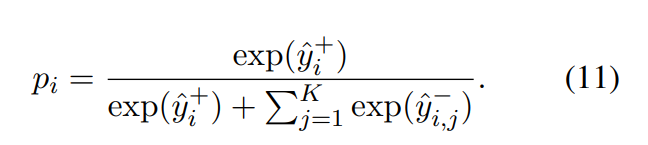

# **Training and validation loop** (Around 6 hours with A800 GPU in colab)

In [ ]:
import os
import torch
from sklearn.metrics import roc_auc_score
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Initialize hyperparameters
hparams = HParams()

# Initialize model
model = NRMSModel(hparams, word2vec_embedding, seed=123)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=hparams.learning_rate, weight_decay=1e-4)
# Scheduler to reduce the learning rate based on validation AUC
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=3, min_lr=1e-6, verbose=True)

# Define paths for saving files
BASE_DIR = "/content/drive/MyDrive/EB_project"
MODEL_NAME = "NRMSModel"
MODEL_WEIGHTS = os.path.join(BASE_DIR, f"state_dict/{MODEL_NAME}/weights.pth")
LOG_DIR = os.path.join(BASE_DIR, f"runs/{MODEL_NAME}")
os.makedirs(os.path.dirname(MODEL_WEIGHTS), exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

# TensorBoard writer
writer = SummaryWriter(log_dir=LOG_DIR)

# Initialize metrics storage
train_losses = []
val_losses = []
train_aucs = []
val_aucs = []

# Training parameters
num_epochs = 6
best_val_auc = 0

# Training loop
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    model.train()

    total_train_loss = 0
    all_train_probs = []
    all_train_labels = []

    for batch_idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        (history_titles, candidate_titles), labels = batch

        # Convert inputs to tensors
        history_titles = torch.tensor(history_titles, dtype=torch.long, device=device)
        candidate_titles = torch.tensor(candidate_titles, dtype=torch.long, device=device)

        labels = torch.tensor(labels, dtype=torch.float, device=device)

        if labels.sum() == 0:  # Skip batches with no positive labels
            continue

        # Forward pass
        scores = model(history_titles, candidate_titles)
        probabilities = torch.softmax(scores, dim=1)

        # Compute loss and update weights
        loss = Negative_samp(scores, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        all_train_probs.extend(probabilities.view(-1).detach().cpu().numpy())
        all_train_labels.extend(labels.view(-1).detach().cpu().numpy())

    avg_train_loss = total_train_loss / (batch_idx + 1)
    train_auc = roc_auc_score(all_train_labels, all_train_probs)
    train_losses.append(avg_train_loss)
    train_aucs.append(train_auc)
    writer.add_scalar("Loss/Train", avg_train_loss, epoch)
    writer.add_scalar("AUC/Train", train_auc, epoch)
    print(f"Training Loss: {avg_train_loss:.4f}, Training AUC: {train_auc:.4f}")

    # Validation loop
    model.eval()
    total_val_loss = 0
    all_val_probs = []
    all_val_labels = []

    with torch.no_grad():
        for batch_idx, batch in enumerate(val_dataloader):
            (history_titles, candidate_titles), labels = batch

            history_titles = torch.tensor(history_titles, dtype=torch.long, device=device)
            candidate_titles = torch.tensor(candidate_titles, dtype=torch.long, device=device)

            labels = torch.tensor(labels, dtype=torch.float, device=device)

            if labels.sum() == 0:
                continue

            # Forward pass
            scores = model(history_titles, candidate_titles)
            probabilities = torch.softmax(scores, dim=1)

            # Compute loss
            loss = Negative_samp(scores, labels)
            total_val_loss += loss.item()
            all_val_probs.extend(probabilities.view(-1).detach().cpu().numpy())
            all_val_labels.extend(labels.view(-1).detach().cpu().numpy())

    # Debugging for NaN values
    print("Any NaN in all_val_probs?", np.isnan(all_val_probs).any())
    print("Any NaN in all_val_labels?", np.isnan(all_val_labels).any())

    if np.isnan(all_val_probs).any() or np.isnan(all_val_labels).any():
        print("NaN found in probabilities or labels! Stopping validation for debugging.")
        exit()

    avg_val_loss = total_val_loss / (batch_idx + 1)
    val_auc = roc_auc_score(all_val_labels, all_val_probs)
    val_losses.append(avg_val_loss)
    val_aucs.append(val_auc)
    writer.add_scalar("Loss/Validation", avg_val_loss, epoch)
    writer.add_scalar("AUC/Validation", val_auc, epoch)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation AUC: {val_auc:.4f}")

    scheduler.step(val_auc)

    # Save the model if validation AUC improves
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(model.state_dict(), MODEL_WEIGHTS)
        print(f"Best model saved with AUC: {val_auc:.4f}")

# Load the best model after training
writer.close()
model.load_state_dict(torch.load(MODEL_WEIGHTS))
print("Model loaded from best checkpoint.")


Using device: cuda

Epoch 1/6
Training Loss: 1.4215, Training AUC: 0.7042
Any NaN in all_val_probs? False
Any NaN in all_val_labels? False
Validation Loss: 1.6033, Validation AUC: 0.5883
Best model saved with AUC: 0.5883

Epoch 2/6
Training Loss: 1.3974, Training AUC: 0.7180
Any NaN in all_val_probs? False
Any NaN in all_val_labels? False
Validation Loss: 1.6078, Validation AUC: 0.5903
Best model saved with AUC: 0.5903

Epoch 3/6
Training Loss: 1.3922, Training AUC: 0.7207
Any NaN in all_val_probs? False
Any NaN in all_val_labels? False
Validation Loss: 1.6223, Validation AUC: 0.5890

Epoch 4/6
Training Loss: 1.3877, Training AUC: 0.7233
Any NaN in all_val_probs? False
Any NaN in all_val_labels? False
Validation Loss: 1.6363, Validation AUC: 0.5880

Epoch 5/6
Training Loss: 1.3817, Training AUC: 0.7270
Any NaN in all_val_probs? False
Any NaN in all_val_labels? False
Validation Loss: 1.6376, Validation AUC: 0.5909
Best model saved with AUC: 0.5909

Epoch 6/6
Training Loss: 1.3637, Train

<ipython-input-101-3c7f8a9f695b>:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_WEIGHTS))


Model loaded from best checkpoint.


# **Plot Train and validation**

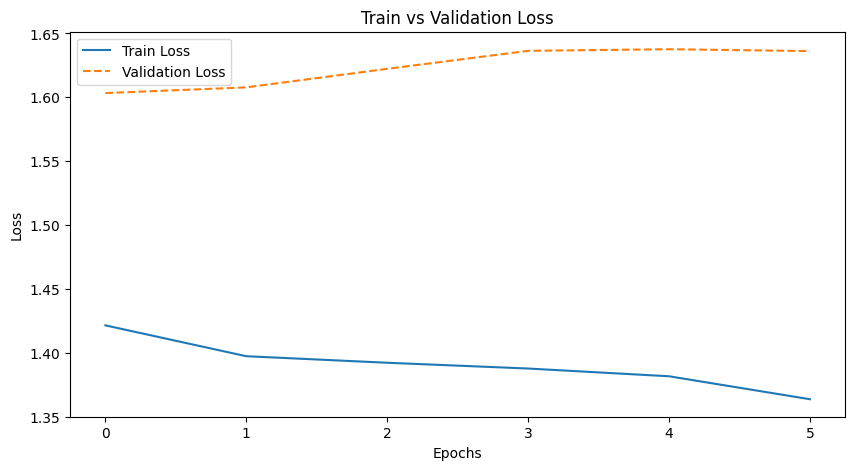

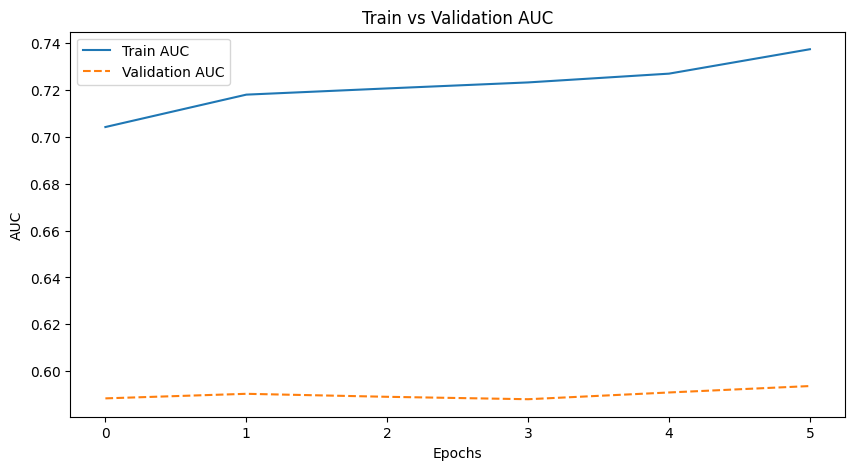

In [ ]:
import matplotlib.pyplot as plt

# Plot Train and Validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

# Plot Train and Validation AUC
plt.figure(figsize=(10, 5))
plt.plot(train_aucs, label='Train AUC')
plt.plot(val_aucs, label='Validation AUC', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('Train vs Validation AUC')
plt.legend()
plt.show()

# **Test/ Evaluation part**

In [ ]:
df_test = (
    ebnerd_from_path(
        PATH.joinpath(DATASPLIT, "validation"),
        history_size=HISTORY_SIZE,
        padding=0,
    )
    .select(COLUMNS)
    .pipe(create_binary_labels_column)
    .sample(fraction=FRACTION)
)
print(len(df_test))

244647


# **Compute predictions**


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import torch
from torch.utils.data import DataLoader
import numpy as np


test_dataloader = NRMSDataLoader(
    behaviors=df_test,
    article_dict=article_mapping,
    unknown_representation="zeros",
    history_column=DEFAULT_HISTORY_ARTICLE_ID_COL,
    eval_mode=True,
    batch_size=32,
)

# --- Testing phase ---
model.eval()  # Set the model to evaluation mode
test_predictions = []

with torch.no_grad():  # Disable gradient calculation for inference
    for batch_idx, batch in enumerate(test_dataloader):
        (history_titles, candidate_titles), labels = batch

        # Move data to device
        history_titles = torch.tensor(history_titles, dtype=torch.long, device=device)
        candidate_titles = torch.tensor(candidate_titles, dtype=torch.long, device=device)

        # Forward pass to get scores
        scores = model(history_titles, candidate_titles)

        # Debug: Print scores and their dimensions

        # Apply softmax to convert scores into probabilities
        probabilities = torch.sigmoid(scores)
        # Debug: Print probabilities

        # Collect predictions
        test_predictions.extend(probabilities.cpu().numpy())

# Convert predictions to numpy array
test_predictions = np.array(test_predictions)


## **Add predictions to dataframe**

In [ ]:
from typing import Iterable
import polars as pl
from ebrec.utils._polars import generate_unique_name
from ebrec.utils._constants import DEFAULT_INVIEW_ARTICLES_COL
import numpy as np


def add_prediction_scores(
    df: pl.DataFrame,
    scores: Iterable[float],
    prediction_scores_col: str = "scores",
    inview_col: str = DEFAULT_INVIEW_ARTICLES_COL,
) -> pl.DataFrame:
    # Generate a unique ID for groupby
    GROUPBY_ID = generate_unique_name(df.columns, "_groupby_id")

    # Add row index as GROUPBY_ID in the original DataFrame
    df = df.with_row_index(name=GROUPBY_ID)

    # Generate prediction scores
    scores = (
        df.lazy()
        .select(pl.col(inview_col), pl.col(GROUPBY_ID))
        .explode(inview_col)
        .with_columns(pl.Series(prediction_scores_col, scores).explode())
        .group_by(GROUPBY_ID)
        .agg(inview_col, prediction_scores_col)
        .sort(GROUPBY_ID)
        .collect()
    )

    return (
        df.join(scores, on=GROUPBY_ID, how="left")
        .drop(GROUPBY_ID)
    )



df_test = add_prediction_scores(
    df=df_test,
    scores=test_predictions.tolist(),
    inview_col="article_ids_inview"
)


## **Compute metrics**

In [ ]:

metrics = MetricEvaluator(
    labels=df_test["labels"].to_list(),
    predictions=df_test["scores"].to_list(),
    metric_functions=[
        AucScore(),
        MrrScore(),
        NdcgScore(k=5),
        NdcgScore(k=10),
        F1Score(threshold=0.5),
    ],
)
results = metrics.evaluate()
print(results)


<MetricEvaluator class>: 
 {
    "auc": 0.5644837382639218,
    "mrr": 0.3459273877558783,
    "ndcg@5": 0.3895380221724382,
    "ndcg@10": 0.46475923210541503,
    "f1": 0.06216195261731217
}


## **Confusion matrix**

True Positives (TP): 19674
False Positives (FP): 203548
True Negatives (TN): 2479772
False Negatives (FN): 225948


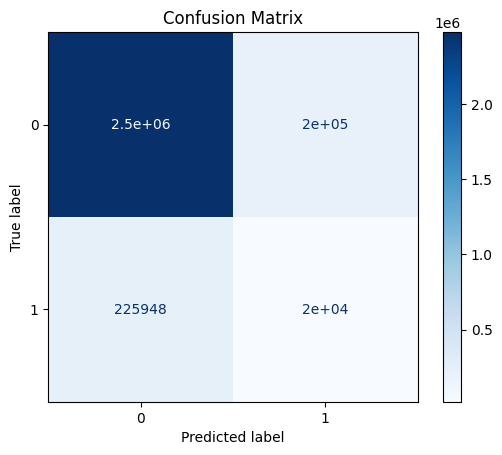

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Extract labels
labels = df_test["labels"].to_list()  # True labels
scores = df_test["scores"].to_list()  # Predicted probabilities

threshold = 0.5
predictions = [[1 if score > threshold else 0 for score in row] for row in scores]

# Flatten labels and predictions
flattened_labels = [label for sublist in labels for label in sublist]
flattened_predictions = [pred for sublist in predictions for pred in sublist]

# Compute the confusion matrix
cm = confusion_matrix(flattened_labels, flattened_predictions)
tn, fp, fn, tp = cm.ravel()

# Print metrics
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")

# Visualize
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


# **Make submission file**

In [ ]:
df_test = df_test.with_columns(
    pl.col("scores")
    .map_elements(lambda x: list(rank_predictions_by_score(x)), return_dtype=pl.List(pl.Float64))
    .alias("ranked_scores")
)
df_test.head(2)

user_id,impression_id,impression_time,article_id_fixed,article_ids_clicked,article_ids_inview,labels,scores,ranked_scores
u32,u32,datetime[μs],list[i32],list[i32],list[i32],list[i8],list[f64],list[f64]
22548,96791,2023-05-28 04:21:24,"[9772629, 9773335, … 9776929]",[9784696],"[9784710, 9784591, … 9783865]","[0, 0, … 0]","[0.505086, 0.388156, … 0.458161]","[1.0, 4.0, … 3.0]"
22548,96798,2023-05-28 04:31:48,"[9772629, 9773335, … 9776929]",[9784281],"[9782726, 9782806, … 9784273]","[0, 0, … 0]","[0.256757, 0.321598, … 0.480301]","[17.0, 11.0, … 4.0]"


## **Sort by ranked length**

In [ ]:
df_test = df_test.with_columns(
    (pl.col("ranked_scores").list.len()).alias("ranked_length")
).sort("ranked_length")
df_test.head(10)

user_id,impression_id,impression_time,article_id_fixed,article_ids_clicked,article_ids_inview,labels,article_ids_inview_right,scores,ranked_scores,ranked_length
u32,u32,datetime[μs],list[i32],list[i32],list[i32],list[i8],list[i32],list[f32],list[f64],u32
22548,96791,2023-05-28 04:21:24,"[9772629, 9773335, … 9776929]",[9784696],"[9784710, 9784696, … 9783865]","[0, 1, … 0]","[9784710, 9784696, … 9783865]","[0.505086, 0.315188, … 0.458161]","[1.0, 5.0, … 3.0]",5
22548,96808,2023-05-28 04:27:19,"[9772629, 9773335, … 9776929]",[9781983],"[9784406, 9781983, … 9695098]","[0, 1, … 0]","[9784406, 9781983, … 9695098]","[0.275019, 0.357309, … 0.008494]","[4.0, 2.0, … 5.0]",5
22548,96824,2023-05-28 04:20:28,"[9772629, 9773335, … 9776929]",[9784679],"[9784591, 9784710, … 9784696]","[0, 0, … 0]","[9784591, 9784710, … 9784696]","[0.388156, 0.505086, … 0.315188]","[4.0, 1.0, … 5.0]",5
25554,97415,2023-05-28 04:14:32,"[9778769, 9778745, … 9780019]",[9784662],"[9783852, 9784559, … 9784662]","[0, 0, … 1]","[9783852, 9784559, … 9784662]","[0.513901, 0.237315, … 0.441586]","[1.0, 4.0, … 2.0]",5
32455,99431,2023-05-28 04:56:13,"[9775908, 9776929, … 9779860]",[9784702],"[9782884, 9784805, … 9784803]","[0, 0, … 0]","[9782884, 9784805, … 9784803]","[0.22477, 0.419131, … 0.522223]","[5.0, 3.0, … 2.0]",5
64661,141196,2023-05-30 14:27:10,"[9775804, 9776369, … 9780096]","[9788188, 9788362]","[9788661, 9788666, … 9788362]","[0, 0, … 1]","[9788661, 9788666, … 9788362]","[0.650391, 0.578955, … 0.596065]","[1.0, 4.0, … 3.0]",5
64661,141197,2023-05-30 14:28:28,"[9775804, 9776369, … 9780096]",[9787499],"[9783042, 9787499, … 9780702]","[0, 1, … 0]","[9783042, 9787499, … 9780702]","[0.33562, 0.427443, … 0.227597]","[4.0, 1.0, … 5.0]",5
84583,146878,2023-05-30 14:08:11,"[9776322, 9775983, … 9779242]",[9785888],"[9785888, 9777339, … 9484153]","[1, 0, … 0]","[9785888, 9777339, … 9484153]","[0.486431, 0.201564, … 0.100334]","[2.0, 4.0, … 5.0]",5
84583,146884,2023-05-30 14:03:15,"[9776322, 9775983, … 9779242]",[9788497],"[9788497, 9788552, … 9788310]","[1, 0, … 0]","[9788497, 9788552, … 9788310]","[0.256722, 0.305633, … 0.390776]","[4.0, 3.0, … 2.0]",5


In [ ]:
df_test = df_test.drop("ranked_length")  # Drop ranked_length

In [ ]:
write_submission_file(
    impression_ids=df_test[DEFAULT_IMPRESSION_ID_COL],
    prediction_scores=df_test["ranked_scores"],
    path=DUMP_DIR.joinpath("predictions.txt"),
    filename_zip=f"{DATASPLIT}_predictions_new3-{MODEL_NAME}.zip",
)



244647it [00:02, 89537.48it/s]


Zipping /content/drive/MyDrive/EB_project/dump_artifacts/predictions.txt to /content/drive/MyDrive/EB_project/dump_artifacts/ebnerd_small_predictions_new3-NRMSModel.zip
